# Introduction to Reinforcement Learning (RL)

New York Computational Psychiatry Workshop

October 21st, 2024


Today, we will learn how to use reinforcement learning (RL) to simulate behavior in different environments (tasks). This tutorial is intended to get you spinning up your own RL algorithms for a task of your choice. As we go along, we will go over both formal definitions and code.

Let us dive in! Go ahead and run the cell below to import some necessary packages.

In [7]:
import numpy as np
from scipy.stats import norm
from scipy.special import logsumexp
import math

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd

## What is reinforcement learning?

**[Reinforcement learning (RL)](http://incompleteideas.net/book/the-book.html)** refers to a set of learning processes that allow agents to make adaptive decisions over time in order to achieve a **goal**. What makes RL different from other types of learning (e.g. supervised learning) is that the feedback used to change behavior (i.e., the **reinforcement**) can be:

1. **Sparse** -- reinforcement doesn't have to occur often
2. **Delayed** -- reinforcement can occur after many actions are taken
3. **Uncertain** -- an action may not always result in reinforcement

*Discussion question*: what are examples of RL that you have encountered in your work?

## Foundations

RL starts from the concept of an **agent** that is acting in an **environment**.

At any given **timepoint** $t$, the agent can be in one of many **states** $s_t \in S$ of the environment, and decide to take one of many **actions** $a_t \in A$. Taking a particular action might switch the agent from $s_t$ to a new state $s_{t+1}$. Once an action is taken, the environment also responds with a reward $r_{t}$.

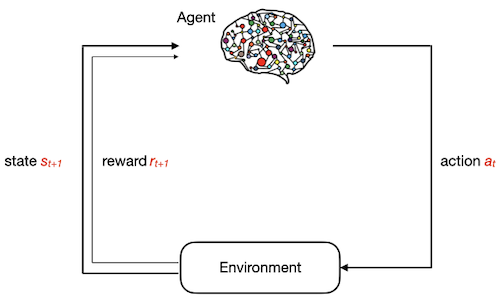

*Discussion question*: how would you define the states and actions of a decision-making scenario that you have encountered in your work?

### Environment

How the environment reacts to the agent's actions is defined by a **model**, which the agent may or may not know. The model has two main components: the transition function $T$ and the reward function $R$.

Let’s say when we are in state $s$, we decide to take action $a$ to arrive in the next state $s’$ and obtain reward $r$. We refer to this as a **transition** step, represented by a tuple $(s, a, s’, r)$. You can think of this tuple as a unit of experience that the agent gets to learn from.

The (repeated) tuples the agent will experience depend on how $T$ and $R$ are defined.

The transition function $T$ defines the probability of transitioning from state $s$ to state $s'$ after taking action $a$ while obtaining reward $r$ (here $\mathbb{P}$ stands for ``probability").

$$
P(s',r | s,a) = \mathbb{P}[S_{t+1} = s', R_{t} = r | S_t = s, A_t = a]
$$

The reward function $R$ predicts the next reward triggered by one action:

$$
R(s,a) = \mathbb{E}[R_{t+1} | S_t = s, A_t = a] = \sum\limits_{r \in R}r\sum\limits_{s' \in S}P(s',r|s,a)
$$

*Example*: let's unpack this some more using a simple "Corridor" environment depicted below.



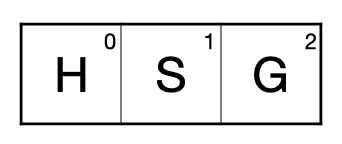

The "Corridor" environment has the following properties:

The state space consists of 3 states. The agent starts in State $1$ (Start), and can reach one of two **terminal** states, State $0$ (Hole) and State $2$ (Goal). When the agent reaches a terminal state, the **episode** (defined as a sequence of experience tuples) ends.

$$
s \in S = \{0, 1, 2\}
$$

The action space consists of two actions available to the agent: Action $0$ (Left) and Action $1$ (Right).

$$
a \in A = \{0, 1\}
$$

The "Corridor" has a **deterministic** transition function: a *Left* action always moves the agent to the left, and a *Right* action always moves the agent to the right.

The "Corridor" reward function gives a +1 when the agent moves into State $2$ (*Goal*) and 0 otherwise.

A convenient way to represent the model of the "Corridor" environment is in table form:

| State  | Action  | Next state  | Transition probability  | Reward  |
|-----------|-----------|-----------|-----------|-----------|
| 0 (Hole) | 0 (Left) | 0 (Hole) | 1  | 0 |
| 0 (Hole) | 1 (Right) | 0 (Hole) | 1  | 0 |
| 1 (Start) | 0 (Left) | 0 (Hole) | 1  | 0 |
| 1 (Start) | 1 (Right) | 0 (Goal) | 1  | +1 |
| 2 (Goal) | 0 (Left) | 2 (Goal) | 1  | 0 |
| 2 (Goal) | 1 (Right) | 2 (Goal) | 1  | 0 |

*Exercise*: Using the formula for the reward function above, compute the reward the agent would expect to get if it starts in the Start state and moves Right.

Let us now code up this environment. To define different components of our simulation, we will make use of [object oriented programming (OOP)](https://realpython.com/python3-object-oriented-programming/). OOP is helpful because it lets us define general classes we can reuse across different simulations to create new instances of each component (e.g. different instances of an agent, environment, etc).


In [3]:
class Corridor(object):

  """Class for the corridor environment."""

  def __init__(self):

    self.n_states = 3
    self.n_actions = 2
    self.states = np.arange(0, self.n_states)
    self.actions = np.arange(0, self.n_actions)
    self.reward_location = self.n_states

    self.state = 1 # begin in Start state
    self.t = 0     # reset timstep
    self.terminate = False

  def visualize(self):

    print("Green is the Goal state")

    xs = np.arange(0, self.n_states+1, 1)
    ys = np.arange(0, 2)

    fig, ax = plt.subplots(1, 1, figsize=(self.n_states,1))
    # grid "shades" (boxes)
    w, h = xs[1] - xs[0], ys[1] - ys[0]
    for i, x in enumerate(xs[:-1]):
        for j, y in enumerate(ys[:-1]):
            if (i == self.reward_location - 1):
                ax.add_patch(Rectangle((x, y), w, h, fill=True, color='#008610', alpha=.1))
    # grid lines
    for x in xs:
        plt.plot([x, x], [ys[0], ys[-1]], color='black', alpha=.33, linestyle=':')
    for y in ys:
        plt.plot([xs[0], xs[-1]], [y, y], color='black', alpha=.33, linestyle=':')

    ax.set_xticks(xs[:-1]+0.5)
    ax.set_xticklabels(xs[:-1]+1)
    ax.set_yticklabels([])
    ax.set_xlabel('State', fontsize=15)

    plt.tick_params(left = False)
    plt.show()

  def step(self, action):

    # the step method takes as input a state and action and changes the environment
    # this is where we encode the environment's true model (T and R)

    assert self.state in self.states, "Invalid state"
    assert action in self.actions, "Invalid action"

    if self.state == 1:
      print('New episode')

    print('Current state: ' + str(self.state))

    if action == 0:
      print('Action: left')
    else:
      print('Action: right')

    if self.state == 1:

        if action == 0:    # agent picks left
            self.state = 0
            reward = 0
        else:              # agent picks right
            self.state = 2
            reward = 1
        self.terminate = 1
        print('+ ' + str(reward) + ' reward')

    elif self.state == 0:
        self.state = 0
        reward = 0
        self.terminate = True
        print('+ ' + str(reward) + ' reward')

    elif self.state == 2:
        self.state = 2
        reward = 0
        self.terminate = True
        print('+ ' + str(reward) + ' reward')

    print('New state: ' + str(self.state))

    # increment timestep
    self.t = self.t + 1
    if self.terminate == True:
      self.reset()
      print('End of episode')

    return self.state, reward

  def reset(self):

    # the reset method resets the environment to its start state
    self.state = 1
    self.terminate == False

Green is the Goal state


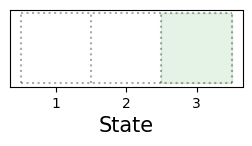

In [5]:
# This line creates an instance of the Corridor class
env = Corridor()

env.visualize()

In [6]:
# This line takes an action and steps through the environment
new_state, reward = env.step(1)

New episode
Current state: 1
Action: right
+ 1 reward
New state: 2
End of episode


Some transition functions are **probabilistic**, meaning that the same action can lead to different states with different probabilities.

*Exercise*: How would you modify the Corridor environment's step function to encode a transition function in which an action works as intended 80% of the time, but 20% of the time the agent "slips" and an action takes the agent to the opposite state?

We may or may not know how the model works and this differentiates two types of RL:

1.   **Model-based RL** - rely on the model of the environment to decide how to act; know the model in advance, or learn it from experience  
2.   **Model-free RL** - no dependency on the model during learning and action selection

Together, these elements (state space $S$, action space $A$, transition function $T$ and reward function $R$) define a **Markov Decision Process (MDP)**. You can think of the MDP as an abstract definition of a particular **task** an agent has to solve.

**Discussion question**: what are some examples of tasks that come to mind which can be thoughht of in this way?

All states in an MDP have the “Markov” property, referring to the fact that the future only depends on the current state, not the history. Or, in other words, the future and the past are conditionally independent given the present, as the current state encapsulates all the statistics we need to decide the future. This is one of the main assumptions of RL.   

### Agent

Another key assumption of RL is that an agent's objective is to maximize long term future reward. This future reward is known as **return**, and it is defined as the total sum of discounted rewards going forward:

$$
G_t = R_{t+1} + \gamma R_{t+2} + ...  = \sum\limits_{k = 0}^{\infty} \gamma^k R_{t+k+1}
$$

The discount factor $\gamma \in [0, 1]$ downweights rewards in the future. It is there for mathematical convenience (we don't need to track future steps forever to compute a return), but also has an interesting psychological interpretation -- we know humans tend to discount benefits that are not immediate.

The agent's **behavior** is represented by a **policy** $\pi$ which encodes what action to take in each state $s$. You can think of this as a function that maps between states and action. This mapping can be either deterministic (always take the same action in a state) or stochastic (take different actions with different probabilities):

$$
\text{Deterministic}: \pi(s) = a
$$

$$
\text{Stochastic}: \mathbb{P}_\pi[A = a|S = s]
$$


### Value

Most RL algorithms in the literature rely on the concept of **value**. Value measures the general "goodness" of a **state** or **state-action** pair: how good is it to be in a state, or how good is it to be in a state and do an action? You can think of these two types of value as mapping onto Pavlovian and instrumental control. From this perspective, Pavlovian learning refers to learning reward predictions; instrumental learning refers to learning what to do, given reward predictions.   

The state-value of a state $s$ is the expected return if we are in this state at time $t$, $S_t = s$:

$$
V_{\pi}(s) =  \mathbb{E}_\pi[G_t | S_t = s]
$$

Similarly, we define the action-value ("Q-value") of a state-action pair as:

$$
Q_{\pi}(s,a) =  \mathbb{E}_\pi[G_t | S_t = s, A_t = a]
$$

By definition, the optimal value function produces the maximum return:

$$
V_*(s) = \max\limits_{\pi}V_{\pi}(s)
$$

$$
Q_*(s, a) = \max\limits_{\pi}Q_{\pi}(s, a)
$$

And the optimal policy achieves the optimal value functions:

$$
\pi_* = \underset{\pi}{\mathrm{argmax}} \ V_\pi(s)
$$

$$
\pi_* = \underset{\pi}{\mathrm{argmax}} \ Q_\pi(s,a)
$$

Most RL algorithms you will encounter in the computational psychiatry literature assume reward maximization defined as above, and aim to have the agent (e.g. human participants, rodents, monkeys) learn the optimal value function and/or the optimal policy. While this discussion is beyond the scope of our tutorial, the limits of this assumption is a matter of active debate in cognitive science ([Juechems & Summerfield](https://www.sciencedirect.com/science/article/pii/S1364661319302001)) and AI ([Silver et al.](https://www.sciencedirect.com/science/article/pii/S0004370221000862), [Abel et al.](https://www.sciencedirect.com/science/article/pii/S0004370221000862)).


### Bellman equations

The **Bellman equations** are a set of recursive update equations that, given complete information of the environment, can be used to directly compute value functions.  These equations decompose the value function into the immediate reward plus the discounted future values.

#### Expectation equations

$$
V_\pi(s) = \sum\limits_{a \in A} \pi(a | s) (R(s,a) + \gamma  \sum\limits_{s' \in S}P_{s,s'}^aV_\pi(s'))
$$

Unpacking the terms:
* $V_\pi(s)$ = the value of state $s$ when following policy $\pi$
* $\pi(a|s)$ = the probability of choosing action $a$ in state $s$
* $R(s,a)$ = the immediate reward obtained after taking action $a$ in state $s$
* $\gamma$ = discount factor
* $P_{s,s'}^a$ = probability of ending up in $s'$ after taking action $a$ in *s*
* $V_\pi(s')$ = the value of state $s'$ when following policy $\pi$

*Discussion question*: does this logic make intuitive sense? Why or why not?

We can write the same kind of relationship for the **state-action value**:

$$
Q_\pi(s,a) = R(s,a) + \gamma   \sum\limits_{s' \in S}P_{s,s'}^a \sum\limits_{a' \in A} \pi(a',s')Q_\pi(s',a')
$$

* $Q_\pi(s,a)$ = the value of taking action $a$ state $s$ when following policy $\pi$
* $R(s,a)$ = the immediate reward obtained after taking action $a$ in state $s$
* $\gamma$ = discount factor
* $P_{s,s'}^a$ = probability of ending up in $s'$ after taking action $a$ in *s*
* $\pi(a|s)$ = the probability of choosing action $a$ in state $s$
* $Q_\pi(s',a')$ = the value of taking action $a'$ state $s'$ when following

*Discussion question*: how does this differ from the state value Bellman equation?

#### Optimality equations

If we are only interested in the **optimal policy**, rather than computing the expectation following any policy, we can modify the expectation equations slightly to compute the maximum returns:

$$
V_*(s) = \max\limits_{a \in A}(R(s,a) + \gamma  \sum\limits_{s' \in S}P_{s,s'}^a V_*(s'))
$$

$$
Q_*(s,a) = R(s,a) + \gamma \sum\limits_{s' \in S} P_{s,s'}^a \max\limits_{a' \in A} Q_*(s',a')
$$

*Discussion question*: these look very similar to the expectation equations, with a few important differences. What are these differences, and what do they mean for the agent's behavior?

#### Dynamic programming

In most scenarios, directly applying the Bellman equations to solve MDPs is impractical. Nevertheless, these equations lay the theoretical foundation for many RL algorithms. For small state and actions spaces, we can use **dynamic programming** to solve the equations and determine the optimal policy. This can be useful, for instance in understanding how the value function of an agent might change under different assumptions about the problem.

*Discussion question*: why would dynamic programming be impractical for large state and action spaces?

*Example paper*: [Zorowitz et al.](https://pubmed.ncbi.nlm.nih.gov/34036174/) used this technique to show how anxious symptomatology can result from relaxing the assumption that the agent makes the return-maximizing choice at each step (as shown in the Bellman optimality equation above).

## Classic RL algorithms

We will now discuss two of the most widely used RL algorithms in the literature: **Temporal-Difference Learning** and **Q-Learning**. While remarkably simple, these algorithms have been extensively studied because of the wealth of evidence suggesting that the brain is implementing this form RL (for a detailed discussion, see this review by [Niv](https://www.sciencedirect.com/science/article/pii/S0022249608001181#fig3)).

### TD-Learning

Temporal-Difference Learning is a general purpose algorithm for learning reward predictions which guarantees convergence to the optimal value function in any MDP. It embodies the key intuition of RL, which is using experience to update reward expectations.

The update equation for TD-Learning is as follows:

$$
V(S_t) \leftarrow V(S_t) + \alpha[R_{t+1} + \gamma V(S_{t+1}) - V(S_t)]
$$

Unpacking the terms:
* $V(S_t)$ = value of current state
* $0 < \alpha < 1$ = learning rate  
* $R_{t+1}$ = immediate reward
* $\gamma$ = discount factor
* $V(S_{t+1})$ = value of future state



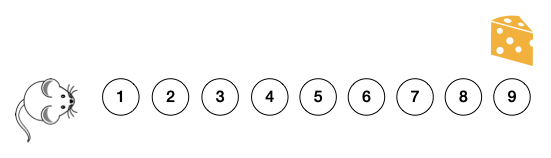

Let us now implement TD-Learning for a simple environment. Consider a mouse running along a track until it reaches a terminal state where it encounters a piece of cheese. We can abstract this as a "single track" in which the agent doesn't take any actions, but simply moves forward on the track.

In [6]:
class SingleTrack(object):

  """Class for the single track environment.

  Parameters
  ----------
  n_states : int
      Number of states on the track.

  """

  def __init__(self, n_states):

    self.n_states = n_states
    self.states = np.arange(0, n_states)
    self.reward_location = self.n_states

    self.state = 1 # begin in Start state
    self.t = 0     # reset timstep
    self.terminate = False

  def visualize(self):

    xs = np.arange(0, self.n_states+1, 1)
    ys = np.arange(0, 2)

    fig, ax = plt.subplots(1, 1, figsize=(self.n_states,1))
    # grid "shades" (boxes)
    w, h = xs[1] - xs[0], ys[1] - ys[0]
    for i, x in enumerate(xs[:-1]):
        for j, y in enumerate(ys[:-1]):
            if (i == self.reward_location - 1):
                ax.add_patch(Rectangle((x, y), w, h, fill=True, color='#f9b02e', alpha=.8))
    # grid lines
    for x in xs:
        plt.plot([x, x], [ys[0], ys[-1]], color='black', alpha=.33, linestyle=':')
    for y in ys:
        plt.plot([xs[0], xs[-1]], [y, y], color='black', alpha=.33, linestyle=':')

    ax.set_xticks(xs[:-1]+0.5)
    ax.set_xticklabels(xs[:-1]+1)
    ax.set_yticklabels([])
    ax.set_xlabel('State', fontsize=15)

    plt.tick_params(left = False)
    plt.show()

  def step(self):

    print('Current state: ' + str(self.state))
    print('Moving right...')
    self.state = self.state+1

    if (self.state == self.reward_location):
        reward = 10;
        self.terminate = True
    else:
        reward = 0;

    print('New state: ' + str(self.state))

    # increment timestep
    self.t = self.t + 1

    return self.state, reward

  def reset(self):

    # the reset method resets the environment to its start state
    self.state = 1
    self.t = 0     # reset timstep
    self.terminate = False


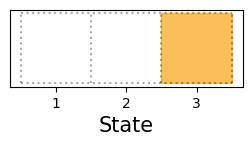

In [7]:
track = SingleTrack(3)
track.visualize()

Time to code up our first agent!

In [8]:
class TDRL(object):
  """Class for the TDRL reward prediction algorithm.

  Parameters
  ----------

  alpha : float, range (0, 1)
      Learning rate.

  gamma : float, range (0, 1)
      Discount factor.

  """

  def __init__(self, env, alpha, gamma, v_init = False):

    self.a = alpha
    self.g = gamma

    # initialize values
    if v_init: # check if initial values were provided
      self.v = np.ones((env.n_states, ))*v_init
    else:
      self.v = np.zeros((env.n_states, ))

    # initialize td-errors
    self.d = np.zeros((env.n_states, ))

  def update(self, current_state, new_state, reward, verbose=False):

    td_error = reward + self.g * self.v[new_state-1] - self.v[current_state-1]

    print('delta: ' + str(td_error))

    self.d[current_state] = td_error
    self.v[current_state-1] = self.v[current_state-1] + self.a * td_error

    if verbose == True:
      print('delta: ' + str(self.v))

It is often convenient to write a simulation function that has the agent and environment interact for a fixed number of trials or episodes.

In [9]:
def run_simulation(params, n_episodes):

  """Function for running a simulation of TDRL in the single track environment."""

  # make environment
  env = SingleTrack(params['n_states'])

  # initialize agent
  agent = TDRL(env, params['alpha'], params['gamma'])

  # initialize output containers
  V = np.zeros((n_episodes, params['n_states']))
  D = np.zeros((n_episodes, params['n_states']))

  for e in np.arange(n_episodes):

    print("Ran the track " + str(e) + " times so far")

    for s in np.arange(params['n_states']):

      # step through environment
      current_state = env.state
      _, reward = env.step()
      new_state = env.state

      # update agent
      agent.update(current_state, new_state, reward, verbose=False)

      if env.terminate:

          V[e,:] = agent.v
          D[e,:] = agent.d

          print('End of episode')
          env.reset()

          break

  return env, V, D

In [10]:
n_episodes = 20

params = {
    'n_states': 10,
    'alpha': 0.2,
    'gamma': 0.9
}

env, V, D = run_simulation(params, n_episodes)

Ran the track 0 times so far
Current state: 1
Moving right...
New state: 2
delta: 0.0
Current state: 2
Moving right...
New state: 3
delta: 0.0
Current state: 3
Moving right...
New state: 4
delta: 0.0
Current state: 4
Moving right...
New state: 5
delta: 0.0
Current state: 5
Moving right...
New state: 6
delta: 0.0
Current state: 6
Moving right...
New state: 7
delta: 0.0
Current state: 7
Moving right...
New state: 8
delta: 0.0
Current state: 8
Moving right...
New state: 9
delta: 0.0
Current state: 9
Moving right...
New state: 10
delta: 10.0
End of episode
Ran the track 1 times so far
Current state: 1
Moving right...
New state: 2
delta: 0.0
Current state: 2
Moving right...
New state: 3
delta: 0.0
Current state: 3
Moving right...
New state: 4
delta: 0.0
Current state: 4
Moving right...
New state: 5
delta: 0.0
Current state: 5
Moving right...
New state: 6
delta: 0.0
Current state: 6
Moving right...
New state: 7
delta: 0.0
Current state: 7
Moving right...
New state: 8
delta: 0.0
Current state

To visualize our results, we can plot the value function:

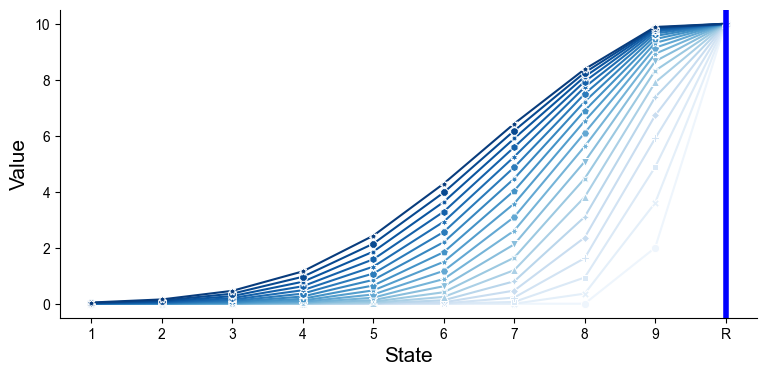

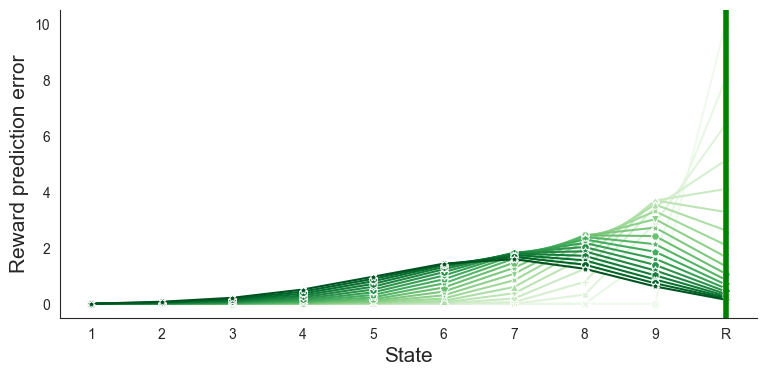

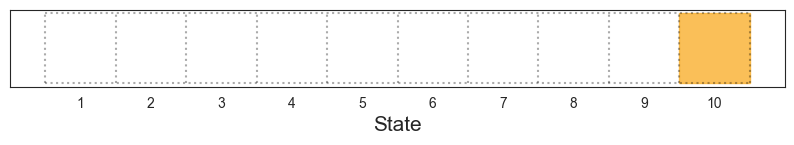

In [11]:
# Value
df_wide = pd.DataFrame(V.T)
df_wide.loc[len(df_wide.index)-1] = 10

fig, ax = plt.subplots(1,1,figsize=(9,4))
sns.lineplot(data=df_wide, legend=False, palette='Blues', markers=True, dashes=False)
ax.legend(labels=list(np.arange(params['n_states'])+1))
ax.axvline(x=params['n_states']-1, color='blue',linewidth=4)
ax.set_xticks(np.arange(params['n_states']))
labels = [str(i) for i in np.arange(params['n_states'])+1]
labels[-1] = 'R'
ax.set_xticklabels(labels)
ax.set_xlabel('State',fontsize=15);
ax.set_ylabel('Value',fontsize=15);
sns.set_style('white');
sns.despine();
plt.gca().get_legend().remove()

# TD-error
df_wide = pd.DataFrame(D.T)

fig, ax = plt.subplots(1,1,figsize=(9,4))
sns.lineplot(data=df_wide, legend=False, palette='Greens', markers=True, dashes=False)
ax.legend(labels=list(np.arange(params['n_states'])+1))
ax.axvline(x=params['n_states']-1, color='green',linewidth=4)
ax.set_xticks(np.arange(params['n_states']))
labels = [str(i) for i in np.arange(params['n_states'])+1]
labels[-1] = 'R'
ax.set_xticklabels(labels)
ax.set_xlabel('State',fontsize=15);
ax.set_ylabel('Reward prediction error',fontsize=15);
sns.set_style('white');
sns.despine();
plt.gca().get_legend().remove()

env.visualize()

One nice intuition for what TD-Learning does is “backing up errors”.
Each line on the value plot  shows you what happens to the value of states preceding the reward when we apply TD-Learning over many episodes (darker lines mean later episodes).  

In early episodes, only the value of states immediately before the reward becomes positive (because that state predicts the imminent reward).

But as the agent experiences this track more and more times, the error gets propagated backwards to earlier states in the track — they each acquire a bit of predictive value.

This is exactly how we think conditioning works: if you walk multiple times to your favorite restaurant and take the same route, in time, you will learn to predict that different parts of your route (like a park or a street corner) lead to reward.

*Discussion question*: What happens to the reward prediction error as the agent experiences the track multiple times? Why?  

*Exercise*: Suppose reward was omitted on a random episode during the task. What do you think would happen to the RPE when the agent reaches the last state during that episode? You can verify your intuition in simulation by modifying the code above. This is exactly the experiment that led to the **[reward prediction error hypothesis](https://www.science.org/doi/10.1126/science.275.5306.1593)** of dopamine function. For a current view of this topic, see this [review](https://www.nature.com/articles/s41593-024-01705-4) by Gershman et al.

### Q-Learning

The TD-Learning algorithm tells us how to update our predictions, but does not tell us how to act. Conveniently, it is possible to extend the logic of learning from temporal differences to estimate $q_\pi(s, a)$ which is the state-action value function for a particular policy.

In fact, if it turns out that if we make the additional assumption that the agent's policy is to simply choose the best action *at the current timestep*, we end up with an update algorithm that [provably](https://link.springer.com/article/10.1007/BF00992698) converges to the optimal policy with enough experience. This is known as **Q-Learning**, and proceeds as follows:

Within one episode, Q-Learning works as follows:

1. Initialize $t = 0$
2. Start in $S_0$
3. At time step $t$, pick the action $A_t$ with the largest Q-Value.
4. After applying action $A_t$, we observe reward $R_{t+1}$ and encounter the next state $S_{t+1}$.
5. Update the Q-value function according to:

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha[R_{t+1} + \gamma \max\limits_{a}Q(S_{t+1},a) - Q(S_t,A_t)]
$$

6. $t = t+1$ and repeat from Step 3.

In the next section, we will show how we can take Q-Learning and turn it into a model of human behavior which we can test against behavioral data.



## From RL algorithms to modeling human behavior

### Simulating behavior

To see how we can apply these ideas to modeling human behavioral data, let's consider a simple environment in which on each trial $t$, a participant makes a choice $c_t$ (= Left or Right) between a left and a right slot machine, and receives a reward $r_t$ (= $\$1$ or $\$0$) stochastically with probability $0.8$ if it chooses Left, or with probability $0.2$ if it chooses Right. This environment is called a **2-armed bandit**, and you can think of it as a "stateless" MDP.

Let's code up this environment below:

In [12]:
class Bandit(object):

  """Class for the multiarmed bandit environment.

  Parameters
  ----------
  k : int
      Number of arms (actions).
  best_action: int
      Best action.
  p_best : float, range (0, 1)
      Reward probability for the best action.
  p_other: float, range (0, 1)
      Reward probability for the other arms.

  """

  def __init__(self, k, best, p_best, p_other, labels=None):

    self.k = k              # number of arms
    self.best_action = best # best action
    self.p_best = p_best    # mean of reward distribution for each arm
    self.p_other = p_other  # standard deviation of reward distribution for each arm
    self.t = 0              # initialize timestep
    self.labels = labels

    self.state = 1          # initialize state: in the simplest bandit setting, this does not change
    self.n_states = 1

  def visualize(self):

    # this method lets us visualize the structure of the environment
    # in the multiarmed bandit case, this consists of the reward distribution for each arm

    p_reward = np.ones((self.k, ))*self.p_other
    p_reward[self.best_action-1] = self.p_best

    sns.barplot(p_reward)
    if self.labels == None:
      labels = np.arange(self.k)+1
    else:
      labels = self.labels
    plt.xticks(np.arange(self.k), labels)
    plt.xlabel('Action')
    plt.ylabel('Reward probability')

  def step(self, action):

    # the step method takes as input an action and changes the environment
    # in the bandit case, the environment responds with a reward

     # draw reward
    if action == self.best_action:
      reward = np.random.choice([1,0], p=[self.p_best, self.p_other])
    else:
      reward = np.random.choice([1,0], p=[self.p_other, self.p_best])

    # increment timestep
    self.t = self.t + 1

    # comment the next line in if you want to print the time step
    # print('timestep: ' + str(self.t))

    return self.state, reward

  def reset(self):

    # the reset method resets the environment to its start state
    self.t = 0

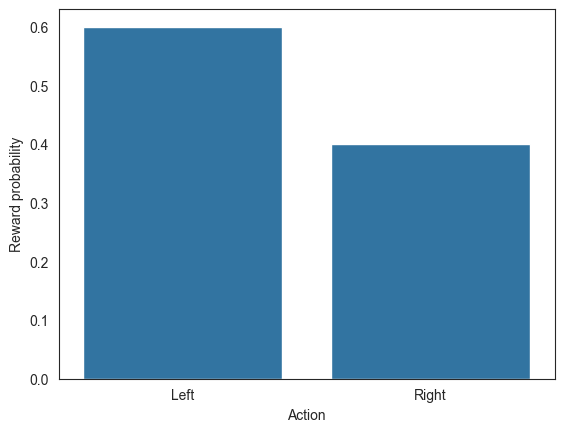

In [13]:
twoarmed = Bandit(2, 1, 0.6, 0.4, labels=['Left', 'Right'])
twoarmed.visualize()

In [14]:
twoarmed.step(2)

(1, 0)

Now let's code up the Q-Learning agent:

In [15]:
class QLearning(object):
  """Class for the Q-learning algorithm.

  Parameters
  ----------

  alpha : float, range (0, 1)
      Learning rate.

  gamma : float, range (0, 1)
      Discount factor.

  epsilon : float, range (0, 1)
      Epsilon probability of exploration.

  """

  def __init__(self, env, alpha, gamma, epsilon, q_init=False):

    # initialize action space
    self.action_space = np.arange(env.k)+1
    self.n_actions = env.k

    self.a = alpha
    self.g = gamma
    self.eps = epsilon

     # initialize Q-values
    if q_init: # check if initial q-values were provided
      self.q = np.ones((env.n_states, env.k))*q_init
    else:
      self.q = np.zeros((env.n_states, env.k))

  def policy(self,state):

    # in the epsilon-greedy case, the agent has an internal representation
    # of the value of each action. its policy is to pick the action with the
    # highest value with probability 1-epsilon and explore a random action with
    # probabilty epsilon.

    # generate random number between 0 and 1.
    # this draws from a uniform distribution, so we have an equal probability
    # of generating any real number between 0 and 1.
    p = np.random.rand()

    # select action
    if (p < self.eps): # is the number we drew is smaller than epsilon?
      action = np.random.choice(self.n_actions)+1 # random action
    else:
      # choose argmax, breaking ties randomly
      action = np.random.choice(np.flatnonzero(self.q[state-1] == self.q[state-1].max())) + 1

    return action

  def update(self, current_state, action, reward, new_state, verbose=False):

    self.q[current_state-1, action-1] = self.q[current_state-1, action-1] + self.a*(reward + self.g * max(self.q[new_state-1, :]) - self.q[current_state-1, action-1])

    if verbose == True:
      print(self.q.flatten())


Simulating behavior from a computational model is the first step of using that model to ask a new scientific question. Simulation involves running the model with particular parameter settings to generate ‘fake’ behavioral data. These simulated data can then be analyzed in much the same way as one would analyze real data, to make precise, falsifiable predictions about qualitative and quantitative patterns in the data. Simulation is a way to make theoretical predictions more precise and testable ([Wilson and Collins](https://elifesciences.org/articles/49547)).

In [16]:
def run_simulation(n_timesteps, params, verbose=False):

  """Function for running one simulation of the two-armed bandit problem.
  It specifies how the environment and agent interact over the course
  of multiple timesteps.

  Parameters
  ----------

  n_timesteps: int
      How many timesteps to run the simulation for

  params : dictionary containing parameters of the simulation

      Environment parameters
      n_arms: int
        Number of arms.
      best_action: int
        Best action.
      p_best : float, range (0, 1)
        Reward probability for the best action.
      p_other: float, range (0, 1)
        Reward probability for the other arms.

      Agent parameters
      alpha : float, range (0, 1)
        Learning rate.
      gamma : float, range (0, 1)
        Discount factor.
      epsilon : float, range (0, 1)
        Epsilon probability of exploration.
      q_initi: float
        Initial value of Q-values.

      verbose: flag for printing some output

  Returns
  ----------

  sim_output: dictionary containing simulation output

      actions: array, int, shape(n_timesteps, )
        Action that the agent took on each timestep.

      rewards: array, float, shape(n_timesteps, )
        Rewards that the agent received on each timestep.

      optimal_action: array, boolean, shape(n_timestep, )
        Indicator vector that tells us if the agent took the best possible action.
  """

  # make environment
  env = Bandit(params['n_arms'], params['best_action'], params['p_best'], params['p_other'])

  # initialize agent
  agent = QLearning(env, params['alpha'], params['gamma'], params['epsilon'], params['q_init'])

  # initialize output lists
  A = [] # action taken at each timestep
  R = [] # rewards on each timestep
  Q = [] # Q-Values at each imestep
  OA = [] # was the optimal action taken at each timestep?

  # loop for given number of timesteps
  for t in np.arange(n_timesteps):

    current_state = env.state

    # record Q-values
    Q.append(agent.q.flatten())

    # agent selects action
    action = agent.policy(env.state)

    # environment responds with a reward
    new_state, reward = env.step(action)

    # record action, reward
    A.append(action)
    R.append(reward)

    # record whether the agent took the optimal action
    optimal_action = (action == env.best_action)
    OA.append(action == optimal_action)

    if verbose:
      print('action: ' + str(action))
      print('reward: ' + str(reward))

    agent.update(current_state, action, reward, new_state, verbose=False)

  # record output in dictionary
  sim_output = {
      'timestep': np.arange(n_timesteps)+1,
      'actions': np.array(A),
      'rewards': np.array(R),
      'q_1': np.array(Q)[:,0],
      'q_2': np.array(Q)[:,1],
      'optimal_action': np.array(OA)
  }

  return env, agent, sim_output

In [17]:
# Run simulation once
n_timesteps = 50
params = {
    'n_arms': 2,
    'best_action': 1,
    'p_best': 0.8,
    'p_other': 0.2,
    'alpha': 0.2,
    'gamma': 1,
    'epsilon': 0.1,
    'q_init': 0
}

sim_env, sim_agent, sim_output = run_simulation(n_timesteps, params)

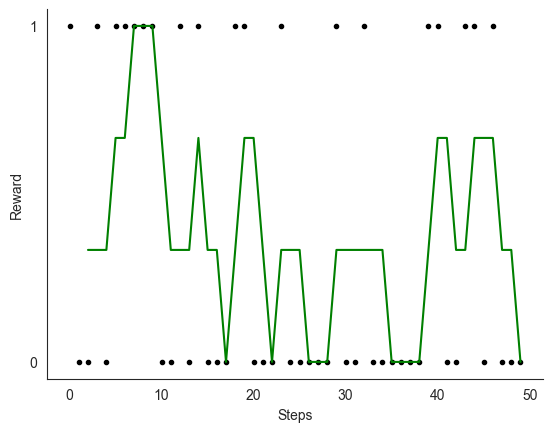

In [18]:
df = pd.DataFrame(sim_output['rewards'])

# Plot reward at each timestep
plt.plot(np.arange(n_timesteps), sim_output['rewards'], '.',color='black')
plt.plot(np.arange(n_timesteps), df.rolling(3).mean(), '-', color='green')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.yticks([0,1])
sns.despine();

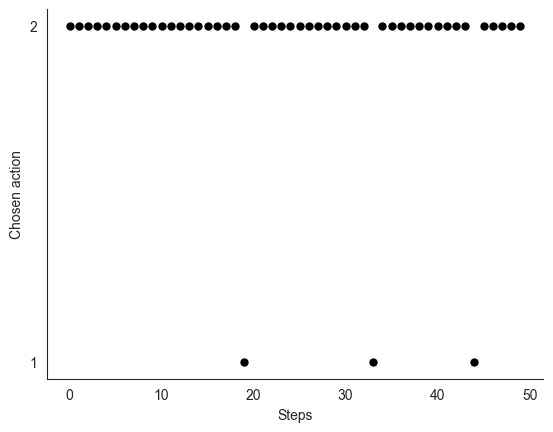

In [19]:
df = pd.DataFrame(sim_output['actions'])

# Plot reward at each timestep
plt.plot(np.arange(n_timesteps), sim_output['actions'], '.', color='black', markersize=10)
plt.xlabel('Steps')
plt.ylabel('Chosen action')
plt.yticks(np.arange(sim_env.k)+1)
sns.despine();

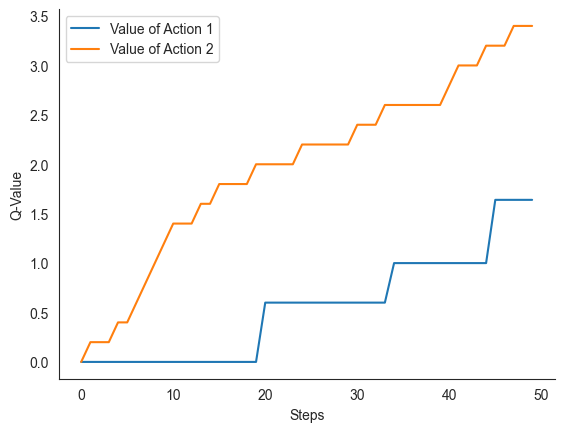

In [20]:
# Plot reward at each timestep
plt.plot(np.arange(n_timesteps), sim_output['q_1'], label='Value of Action 1')
plt.plot(np.arange(n_timesteps), sim_output['q_2'], label='Value of Action 2')
plt.xlabel('Steps')
plt.ylabel('Q-Value')
plt.legend()
sns.despine();

Simulation is useful in exploring how the behavior of the agent changes as a function of different parameters. Below is an example of examining how the performance of the agent changes as a function of learning rate.

In [21]:
# Run simulation many times for different values of alpha
n_runs = 500

# Initialize output list
D = []

for a in [0.001, 0.25, 0.5]:

  q = 0

  print('a = '  + str(a))
  print('q init = '  + str(q))

  for r in np.arange(n_runs):

    print('simulation #: ' + str(r+1))

    n_timesteps = 20

    params = {
      'n_arms': 2,
      'best_action': 1,
      'p_best': 0.7,
      'p_other': 0.3,
      'alpha': a,
      'gamma': 1,
      'epsilon': 0.2,
      'q_init': q
    }

    _, _, sim_output = run_simulation(n_timesteps, params)

    # convert to dataframe and append to list
    d = pd.DataFrame(sim_output)
    d.insert(0, 'run', r+1)
    d.insert(1, 'alpha', params['alpha'])
    d.insert(2, 'q_init', params['q_init'])
    D.append(d)

data = pd.concat(D, ignore_index=True)

a = 0.001
q init = 0
simulation #: 1
simulation #: 2
simulation #: 3
simulation #: 4
simulation #: 5
simulation #: 6
simulation #: 7
simulation #: 8
simulation #: 9
simulation #: 10
simulation #: 11
simulation #: 12
simulation #: 13
simulation #: 14
simulation #: 15
simulation #: 16
simulation #: 17
simulation #: 18
simulation #: 19
simulation #: 20
simulation #: 21
simulation #: 22
simulation #: 23
simulation #: 24
simulation #: 25
simulation #: 26
simulation #: 27
simulation #: 28
simulation #: 29
simulation #: 30
simulation #: 31
simulation #: 32
simulation #: 33
simulation #: 34
simulation #: 35
simulation #: 36
simulation #: 37
simulation #: 38
simulation #: 39
simulation #: 40
simulation #: 41
simulation #: 42
simulation #: 43
simulation #: 44
simulation #: 45
simulation #: 46
simulation #: 47
simulation #: 48
simulation #: 49
simulation #: 50
simulation #: 51
simulation #: 52
simulation #: 53
simulation #: 54
simulation #: 55
simulation #: 56
simulation #: 57
simulation #: 58
si

In [22]:
# Examine output
data

,run,alpha,q_init,timestep,actions,rewards,q_1,q_2,optimal_action
0,1,0.001,0,1,2,0,0.0,0.0,False
1,1,0.001,0,2,1,0,0.0,0.0,True
2,1,0.001,0,3,2,0,0.0,0.0,False
3,1,0.001,0,4,2,0,0.0,0.0,False
4,1,0.001,0,5,1,1,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...
29995,500,0.500,0,16,2,0,4.0,2.0,False
29996,500,0.500,0,17,1,1,4.0,3.0,True
29997,500,0.500,0,18,1,0,4.5,3.0,True
29998,500,0.500,0,19,1,0,4.5,3.0,True


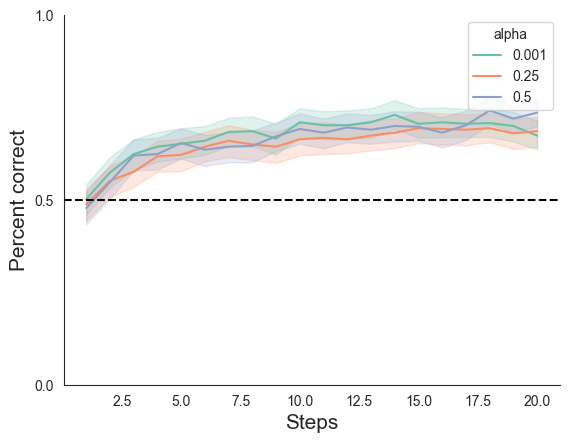

In [23]:
# Plot percent correct across different runs
fig, ax = plt.subplots(1, 1)
sns.lineplot(data=data, x="timestep", y="optimal_action", hue='alpha', ax=ax, palette='Set2')
ax.set_ylim([0, 1])
ax.set_yticks([0, 0.5, 1])
plt.axhline(y=0.5,linestyle='--',color='black')
ax.set_xlabel('Steps', fontsize=15)
ax.set_ylabel('Percent correct', fontsize=15)
sns.despine();

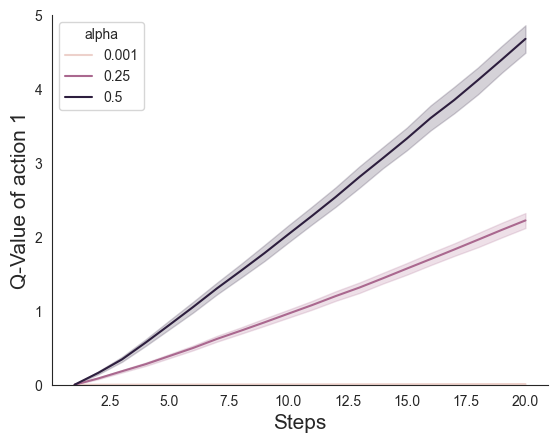

In [24]:
# Plot percent correct across different runs, for each value of epsilon
fig, ax = plt.subplots(1, 1)
sns.lineplot(data=data, x="timestep", y="q_1", hue="alpha")
ax.set_ylim(([0,5]))
ax.set_xlabel('Steps', fontsize=15)
ax.set_ylabel('Q-Value of action 1', fontsize=15)
sns.despine();

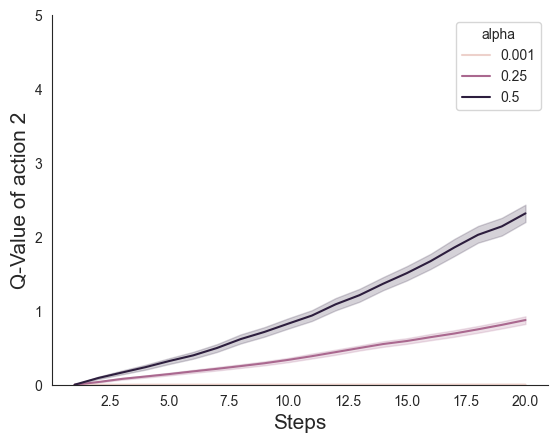

In [25]:
# Plot percent correct across different runs, for each value of epsilon
fig, ax = plt.subplots(1, 1)
sns.lineplot(data=data, x="timestep", y="q_2", hue="alpha")
ax.set_ylim(([0,5]))
ax.set_xlabel('Steps', fontsize=15)
ax.set_ylabel('Q-Value of action 2', fontsize=15)
sns.despine();

*Exercise*: how would you modify the reward function of the environment to introduce a "reversal", in which the best action changes halfway through the task? Try that and re-run the simulation. How does the performance of the agent change as a function of learning rate?

### The likelihood function

In order to fit human behavior, we need some way to link between internal variables of the algorithm (e.g., value) and choice data from a behavioral experiment. In value-based decision making and learning experiments, it is often assumed that participants choose probabilistically according to a *softmax* distribution:

$$
P(c_t = L | Q_t(L), Q_t(R)) = \frac{\exp(\beta Q_t(L))}{\exp(\beta Q_t(L) + \exp(\beta Q_t(R))}
$$

Here, $\beta$ is a free parameter known as inverse temperature. You may have encountered this **link function** in logistic regression. Indeed, the choice model above is equivalent to that of logistic regression, where the dependent variable is the binary choice $c_t$ and there is one predictor variable, the difference in values $Q_t(L) - Q_t(R)$. The larger this value difference, the more biased an agent will be towards one of the options.

Given a particular learning model (e.g. Q-Learning) and the softmax choice model, the probability of a whole dataset (i.e. a whole sequence of choices *$c$* = $c_1, ..., c_T$ given the rewards *$r$* = $r_1, ..., r_T$) is just a product of the probabilities from the equation above:

$$
\prod_{t} P(c_t = L | Q_t(L), Q_t(R))
$$

This likelihood function is central to several model fitting methods you will learn about tomorrow.

## Task example: RL with attention

Standard Q-Learning works well in scenariors in which states and actions are well defined, and the number of states to learn from is small, allowing the agent to acquire enough experience in a short amount of time.

Let's consider a more realistic situation in which we have to use experience to make a decision. Say our goal was to take the subway in Times Square to get Uptown, but we have never been to New York before.

*Discussion question*: What aspects of the environment should we pay attention to?

Some possibilities:
* Color of subway lines (yellow, red, blue, etc.)
* Shape (circle or diamond)
* Symbol (letter or number)
* Street (42nd st, 72nd, etc)

It takes a long time to learn which of these features are the most relevant for achieving our goals. Learning relevant features can help us focus on what’s important, plan better, and know exactly what actions to take in what situations.

The **curse of dimensionality** refers to the problem faced by all agents that as we add more features to the state, the number of possible states we can visit grows exponentially:

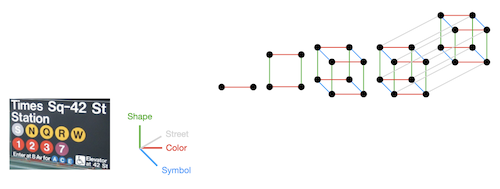

A possible solution to this is to use **selective attention** to learn relevant features of a task.

The interaction between selective attention and learning has been studied using multidimensional reinforcement learning tasks (for a metanalytic review, see [Radulescu et al., 2019](https://www.cell.com/trends/cognitive-sciences/abstract/S1364-6613(19)30036-1?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS1364661319300361%3Fshowall%3Dtrue)). We will use a version of this class of tasks from [Radulescu et al., 2016](https://www.angelaradulescu.com/lib/RadulescuEtAl2016.pdf) to explore different ways we could integrate attention into RL models.

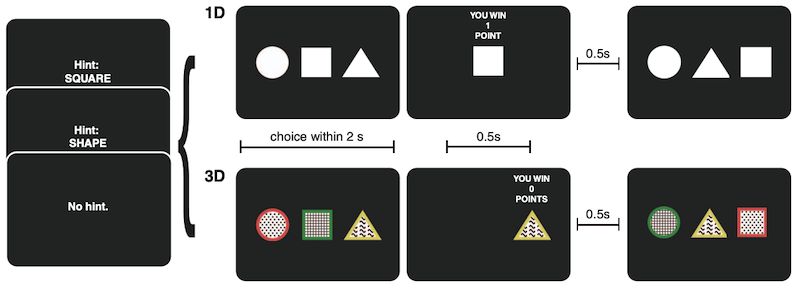

In this task, there is one relevant dimension (e.g. color) and one target feature $f*$ (e.g. red), such that:

$$
p(\text{reward} | f^* \in \text{chosen}) = 0.75
$$

$$
p(\text{reward} | f^* \notin \text{chosen}) = 0.25
$$

Participants have 2 seconds to choose on each trial, and then they observe the outcome (1 or 0) for 500ms. On the next trial, the features reshuffle within each dimension.

Participants go through several blocks, where each block consists of 18-25 trials.

Before each block, participants receive a hint about the target feature, the relevant dimension, or no hint.


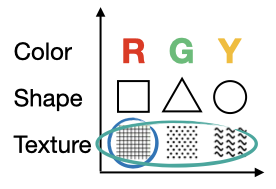

*Discussion question*: What are the similarities and differences between this task and the two-armed bandit?

*Discussion question*: How does the state space of this task environment change as a function of attention condition?

As before, let's start by coding up the environment.


In [26]:
# Library of functions for defining a multidimensional environment with
# discrete features. Probability of reward is highest for a target feature
# that changes with probability h.

# Note the slight change in

class MultidimensionalRL(object):
	"""Container for world that the agent is learning in.

	Parameters
	----------
	n_dims : int
	    Number of dimensions along which world varies.
	n_feats_per_dim : int
	    Number of discrete features per dimension.
	n_feats : int
	    Number of total features
	obs_space: array, n_dims by n_feats per dim, int
	    Array corresponding to full observation space.
	target: int
		Target feature.
	outcome: float
		Outcome value.
	h: float
		Rate of change for target.
	p_high: float
		Rate of reward given target.
	p_low: float
		Rate of reward not given target.
	"""

	def __init__(self, n_dims, n_feats_per_dim, h, p_high, p_low, outcome, target=None):

        ## Define observation space.
		self.n_dims = n_dims
		self.n_feats_per_dim = n_feats_per_dim
		self.n_feats = n_dims * n_feats_per_dim
		# Make array corresponding to full observation space.
		os = np.zeros([n_dims, n_feats_per_dim])
		for d in np.arange(0, n_dims)+1:
			if d == 1:
				os[d-1,] = np.arange(0, n_feats_per_dim)+1
			else:
				os[d-1,] = np.arange(1, n_feats_per_dim+1) + (d-1)*n_feats_per_dim
		self.obs_space = os

        ## Define state model.
        # If not provided, randomly select relevant feature
		if target is None:
			self.target = np.random.randint(self.n_feats)+1
		else:
			self.target = target
        # Probability with which target feature changes
		self.h = h

        ## Define reward function.
        # Probability of observing outcome given target feature is present
		self.p_high = p_high
        # Probability of observing outcome given target feature is not present
		self.p_low = p_low
        # Magnitude of binary outcome
		self.outcome = outcome

	def make_stimuli(self):

		"""Returns one instance of all possible stimuli given the feature space, coded in
		two ways.

		Returns
	    -------
	    stimuli1 : array, int, shape(n_dims, n_feats_per_dim)
	        Rows are dimensions and columns are features. Non-expanded coding.

	    stimuli2 : array, int, shape(n_dims, n_feats_per_dim)
	    	Same as above, expanded coding (features are labeled 1-n_feats).

	    single_stim : array, int, shape(1, n_feats_per_dim)
	   		Randomly selected single stimulus.

		"""

		stimuli1 = np.random.permutation(np.arange(self.n_feats_per_dim)+1)
		stimuli2 = stimuli1

		## Loop through dimensions.
		for d in np.arange(self.n_dims-1)+1:

			## Permute features.
			new = np.random.permutation(np.arange(self.n_feats_per_dim)+1)

			## Stack on top previous features.
			stimuli1 = np.vstack((stimuli1,new))
			stimuli2 = np.vstack((stimuli2, new + self.n_feats_per_dim*(d)))

		## Draw one stimulus at random.
		a_rand = np.random.randint(1,self.n_feats_per_dim+1)
		single_stim = stimuli2[:,a_rand-1]

		return stimuli1, stimuli2, single_stim

	def make_observations(self, n_trials):
		""" Convenience function for generating random observation sequences of a
			given length. Each observation consists of a [stimulus, outcome] pair.
		"""

		stimuli = np.empty((0,self.n_feats_per_dim))
		outcomes = np.empty(n_trials)

		## Loop through trials.
		for t in np.arange(n_trials):

			## Generate a random stimulus.
			d, e, stimulus = self.make_stimuli()
			stimuli = np.vstack((stimuli, stimulus))

			## Compute outcome.
			outcomes[t] = self.generate_outcome(stimulus)

		return stimuli, outcomes

	def plot_observations(self, stimuli, outcomes, target=None):
		""" Plots sequence of observations (choices and outcomes).
			Can be used with both simulated and real data.
		"""

		import matplotlib.pyplot as plt
		import seaborn as sns

		n_trials, d = stimuli.shape

		## If target is not provided, get default from world.
		if target is None: target = self.target

		fig, ax = plt.subplots(1, 1, figsize=(12,4));
		win_col = '#4dac26'
		loss_col = '#bababa'
		sz_targ = 16
		sz_nontarg = 16
		# plt.axhline(y=target, color='#f0f0f0', linestyle='-',linewidth='18')
		for t in np.arange(n_trials):
		    if outcomes[t] == 1:
		        for d in np.arange(self.n_dims):
		            if stimuli[t,d] == target:
		                plt.plot(t+1, stimuli[t,d],'s', color=win_col, markersize=sz_targ, markeredgecolor='#252525', markeredgewidth=2)
		            else:
		                plt.plot(t+1, stimuli[t,d],'s', color=win_col, markersize=sz_nontarg)
		    else:
		        for d in np.arange(self.n_dims):
		            if stimuli[t,d] == target:
		                plt.plot(t+1, stimuli[t,d],'s', color=loss_col, markersize=sz_targ, markeredgecolor='#252525', markeredgewidth=2)
		            else:
		                plt.plot(t+1, stimuli[t,d],'s', color=loss_col, markersize=sz_nontarg)

		ax.set_xlim((0, n_trials+1));
		ax.set_ylim((0, self.n_feats+2));
		ax.set_xticks(np.arange(n_trials)+1);
		ax.set_yticks(np.arange(self.n_feats)+1);
		xl = ax.set_xlabel('Trial',fontsize = 20);
		yl = ax.set_ylabel('Feature',fontsize = 20);
		ax.tick_params(labelsize=20)
		plt.ylim([0,self.n_feats+1])
		# sns.despine()

		return fig, ax

	def generate_outcome(self, stimulus, target=None):

		"""Generates binary outcome given stimulus. Requires "stimuli2" coding from
		make_stimuli

		Parameters
	    -------
	    stimulus : array, int, shape(n_dims, 1)
	    	Expanded coding.

	    target: int
	    	If target feature not provided, uses default from self.

		Returns
	    -------
	    outcome : int, 0 or 1

		"""

		## If target is not provided, get default from world.
		if target is None: target = self.target

		## Compute outcome.
		if target in stimulus:
			outcome = int((np.random.rand() < self.p_high))
		else:
			outcome = int((np.random.rand() < self.p_low))

		return outcome

Let's test it out!

In [27]:
env = MultidimensionalRL(n_dims=3, n_feats_per_dim=3, h=0, p_high=0.75, p_low=0.25, outcome=1, target=1)

In [28]:
s, o = env.make_observations(n_trials=20)

(<Figure size 1200x400 with 1 Axes>, <Axes: xlabel='Trial', ylabel='Feature'>)

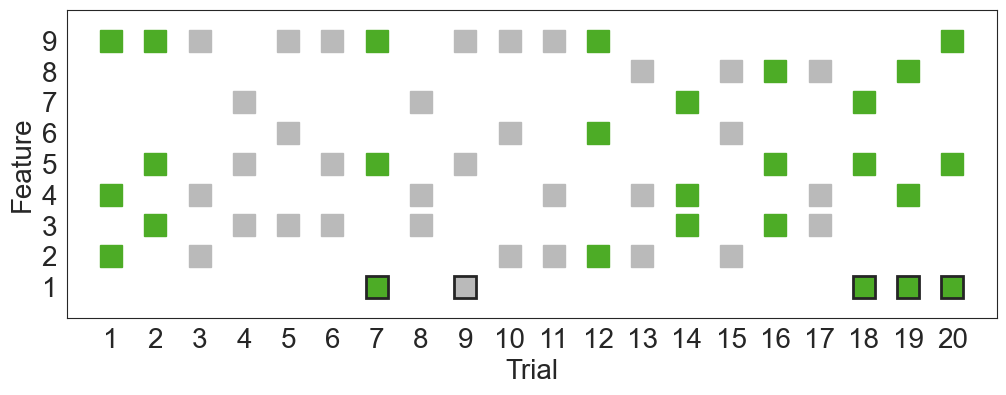

In [29]:
env.plot_observations(s,o)

Now let's code up the agent! For this task, we will use a **feature reinforcement learning** algorithm. It is similar to TDRL and Q-Learning, except instead of learning over individual stimuli, it learns over stimulus features, weighted by attention:

$$
V_t(S_i) = \sum\limits_{d=1}^{3}w_t(f_d)\phi_d
$$

* $V_t(S_i)$ = value of stimulus $i$
* $w_t(f_d)$ = value of the feature in dimension $d$
* $\phi_d$ = attention weight for dimension $d$

Values are passed through a softmax action selection function:

$$
p(c_t = S_i | V_t(S_i)) = \frac{\exp^{\beta V_t(S_i)}}{\sum_j \exp^{\beta V_t(S_j)}}
$$

* $p(c_t = S_i | V_t(S_i))$ = probability of choosing $S_i$ given its value $V_t(S_i)$
* $\beta$ = inverse choice temperature

Once a choice is made, the weights of the chosen features are updated in proportion to the reward prediction error multiplied by a learning rate, and weighted by attention:

$$
w_{t+1}(f_c) = w_t(f_c)+\eta[R_t - V_t(S_c)]\phi_d
$$

* $w_t(f_c)$ = value of the chosen features
* $\eta$ = learning rate
* $R_t$ = reward at time $t$  
* $V_t(S_c)$ = value of the chosen stimulus
* $\phi_d$ = attention weight for dimension $d$

Finally, non-chosen feature weights are decayed to 0:

$$
w_{t+1}(f \notin \text{chosen}) = (1-\eta_k) w_{t}(f \notin \text{chosen})
$$


*Exercise*: Parameter $\phi_d$ indexes attention to each of the 3 dimensions. How might you set it in each of the three conditions of the task, and what does this mean for the learning processs?  

In [32]:
# Feature reinforcement learning class.

# Instantiates a feature reinforcement learning agent that is learing
# in a multidimensional environment with discrete features.

# Start Agent class.
class FeatureRL(object):
    """ Container for agent properties and methods.

    Parameters.
    ----------
    world:
        instance of World.
    eta: float
        Learning rate.
    eta_k: float
        Decay rate.
    beta_value_choice: float
        Softmax temperature for choice linking function.
    w_init: float
        Initial feature values. Can be a single float encoding a single
        initial value of each feature or an array of floats.
    decay_target: float
        Value to decay feature weights towards.
    ----------
    """

    ###############################
    ## Initialize agent properties.
    ###############################
    def __init__(self, world, params):
        """ Sets agent parameters.
        """

        self.eta = params['learning_rate']
        self.eta_k = params['decay_rate']
        self.phi_hat = params['phi_hat']
        self.beta_value_choice = params['beta_value_choice']
        self.w_init = params['w_init']
        self.dt = params['decay_target']
        self.precision = params['precision']

    def compute_values(self, world, stimuli, w):

        """ Value computation for stimuli.

            Parameters
            ----------
            stimuli: array, int, shape(n_feats_per_dim, n_dims)
                Stimulus array on a given trial.

            w: array, float, shape(1, n_feats_per_dim * n_dims)
                Array of feature weights.

            Returns
            -------
            v: array, float, shape(n_feats_per_dim, )
                Array of stimulus values.

        """

        ## Retrieve stimulus feature values.
        # This will be an array of the same dimensionality as "stimuli".
        w_stim = np.reshape(w[np.reshape(stimuli-1,(1,-1))], (world.n_feats_per_dim, world.n_dims))

        ## Set attention to uniform.
        phi = np.ones(world.n_dims)

        ## Compute values by taking dot product.
        v = np.dot(w_stim, phi)

        return v

    def softmax(self, v):
        """ Softmax action selection for an arbitrary number of actions with values v.
            Ref. on logsumexp: https://blog.feedly.com/tricks-of-the-trade-logsumexp/

            Parameters
            ----------
            v: array, float
                Array of action values.

            Returns
            -------
            p_c: array, float bounded between 0 and 1
                Probability distribution over actions
            a: int
                Chosen action.
        """

        ## Convert values to choice probabilities.
        v_b = self.beta_value_choice * v;
        p_c = np.exp(v_b - logsumexp(v_b));

        ## Uniformly sample from cumulative distribution over p_c.
        if math.isnan(self.beta_value_choice) is not False:
            assert "Invalid parameter value"

        a = np.nonzero(np.random.random((1,)) <= np.cumsum(p_c))[0][0] + 1

        return p_c, a

    ######################
    ## Simulation methods.
    ######################

    def run_with_choice(self, world, n_trials, stimuli=None):

        """ Runs one simulation of the RL model.

            Parameters
            ----------
            world: instance of World.

            n_trials: int
                How many trials should the agent run for. If 'stimuli' is provided, this value will
                be overriden by the length of the stimulus sequence.

            stimuli: list, len(n_trials)
                Sequence of stimuli, expanded coding.

            Returns
            -------

            W: float, array(n_trials, n_feats)
                Feature values on each trial.

        """

        ## Get number of trials.
        if stimuli is not None: n_trials = len(stimuli);

        ## Initialize output variables.
        W = np.empty((0, world.n_feats))
        V = np.empty((0, world.n_feats_per_dim))
        P_C = np.empty((0, world.n_feats_per_dim))
        Chosen = np.empty((0, world.n_dims))
        C = np.empty(n_trials)
        O = np.empty(n_trials)

        ## Initialize feature weights.
        w = self.w_init * np.ones(world.n_feats)

        ## Loop through trials.
        for t in np.arange(n_trials):

            ## Store feature values.
            W = np.vstack((W, w.T))

            ## Generate stimuli.
            if stimuli is None:
                stim1, stim2, single_stim = world.make_stimuli()
            else:
                stim2 = stimuli[t]

            ## Compute values.
            v = self.compute_values(world, stim2, w)
            V = np.vstack((V, v))

            ## Choose an action.
            p_c, a = self.softmax(v)
            P_C = np.vstack((P_C, p_c))
            choice = stim2[a-1,:]
            Chosen = np.vstack((Chosen, choice))

            ## Mark if correct.
            if world.target in choice: C[t] = 1
            else: C[t] = 0

            ## Observe outcome.
            outcome = world.generate_outcome(choice)
            O[t] = outcome

            ## Set attention to uniform.
            phi = np.ones(world.n_dims)

            ## Update chosen weights.
            pe = outcome-np.sum(w[choice-1])
            w[choice-1] = w[choice-1] + self.eta * pe * [choice-1] * phi

            ## Decay unchosen weights.
            all_feats = np.arange(world.n_feats)+1
            unchosen_feats = all_feats[~np.isin(all_feats, choice)]
            w[unchosen_feats-1] = (1-self.eta_k) * w[unchosen_feats-1]

        return W, V, P_C, Chosen, C, O

    ########################
    ## Likelihood functions.
    ########################

    def choice_likelihood(self, world, extracted_data):

        """ Returns the log likelihood of a sequence of choices.

            Parameters
            ----------
            world: instance of World.

            extracted_data: dictionary of extracted variables.

            Contains:

                stimuli: int, shape(n_trials, n_feats_per_dim, n_dims)
                    Each available stimulus, expanded coding as defined in World.make_stimuli.

                choices: int, shape(n_trials, n_dims)
                    Sequence of chosen stimuli, expanded feature coding as defined in World.make_stimuli

                actions: int, shape(n_trials, 1)
                    Sequence of chosen actions.

                outcomes: int, shape(n_trials, 1)
                    Sequence of outcomes.

            Returns
            -------
            w_all: float, array(n_trials, n_feats)
                Learned feature weights.

            log_lik: float
                Log-likelihood of choices.
        """

        ## Remap dictionary to necessary local variables.
        outcomes = extracted_data["outcomes"]
        stimuli = extracted_data["stimuli"]
        choices = extracted_data["choices"]
        actions = extracted_data["actions"]

        ## Get number of trials.
        n_trials = len(outcomes)

        ## Preallocate value array.
        w_all = np.ones((n_trials, world.n_feats)) * np.nan

        ## Initialize feature weights.
        W = self.w_init * np.ones(world.n_feats)

        ## Initialize likelihood.
        log_lik = 0

        ## Loop through trials.
        for t in np.arange(n_trials):

            ## Store current W.
            w_all[t,:] = W

            ## Compute current value.
            V = self.compute_values(world, stimuli[t], W)

            ## Compute action likelihood.
            p_c, a = self.softmax(V)
            log_p_c = np.log(p_c)
            trial_lik = log_p_c[actions[t].astype(int)-1]
            log_lik = log_lik + trial_lik

            ## Observe outcome.
            outcome = outcomes[t].astype(int)

            ## Grab current choice.
            choice = choices[t].astype(int)

             ## Set attention to uniform.
            phi = np.ones(world.n_dims)

            ## Update chosen weights.
            pe = outcome-np.sum(W[choice-1])
            W[choice-1] = W[choice-1] + self.eta * pe * phi
           
            ## Decay unchosen weights.
            all_feats = np.arange(world.n_feats)+1
            unchosen_feats = all_feats[~np.isin(all_feats, choice)]

            W[unchosen_feats-1] = (1-self.eta_k) * W[unchosen_feats-1]

        return w_all, log_lik


Let's now generate one dataset's worth of data on the task... 

In [37]:
_, stim, _ = env.make_stimuli()
stim

def simulate_rt(entropies, b, eps): 
    
    RT = []
    for e in entropies: 
        rt = (b * e + np.random.normal(0, eps))
        RT.append(rt)
        
    return RT

array([[1, 3, 2],
       [5, 4, 6],
       [7, 9, 8]])

Finally, let's run a simulation testing the behavioral predictions of group difference in decay rate:

In [31]:
n_runs = 100
n_blocks = 10
block_length = 20

P_accuracy = []
P_rt = []

for r in np.arange(n_runs):

    print(s)

    CORRECT = []
    RT = []
    LEARNED = []

    for block in np.arange(n_blocks):

        ### replace this with simulated data
        stimuli = list(block_data['stimuli_expanded'].values)
        target = block_data['target_feature'].values[0].astype(int)
        condition = block_data['condition'].values[0]
        ### replace this with simulated data

        if condition == 'younger_adults':

            eta = 0.2
            eta_k = 0.4
            beta = 10
            w_init = 0
           
        elif condition == 'older_adults':

            eta = 0.2
            eta_k = 0.8
            beta = 10
            w_init = 0
           
        # Make environment.
        env = MultidimensionalRL(n_dims=2, n_feats_per_dim=3, h=0, p_high=0.75, p_low=0.25, outcome=1, target=target)

        # Make agent again.
        params = {'learning_rate': eta,
                'decay_rate': eta_k,
                'beta_value_choice': beta,
                'w_init': w_init,
                'decay_target': 0,
                'precision': 0}

        agent = FeatureRL(world, params)

        W, V, P_C, Chosen, C, O = agent.run_with_choice(env, 0, stimuli)
        CORRECT.append(C)
        rt = simulate_rt(entropy(P_C, axis=1), 1300, 50)
        RT.append(rt)

        correct_last_6 = C[-7:-1]

        if (np.sum(correct_last_6) == 5):
            learned = 1;
        else:
            learned = 0;

        LEARNED.append(np.ones(len(C)) * learned)

    # Make copy of actual data in order to retain other info & replace observed with simulated.
    DATA_SIM = DATA.copy()
    DATA_SIM['correct'] = np.concatenate(CORRECT)
    DATA_SIM['rt'] = np.concatenate(RT)
    DATA_SIM['learned'] = np.concatenate(LEARNED)

    # Compute accuracy
    df = DATA_SIM.groupby(['subject','condition'], as_index=False).mean()

    t, p = stats.ttest_rel(df[df['condition'] == 'high']['correct'].values, df[df['condition'] == 'low']['correct'].values)
    P_accuracy.append(p)

    t, p = stats.ttest_rel(df[df['condition'] == 'high']['rt'].values, df[df['condition'] == 'low']['rt'].values)
    print(p)
    P_rt.append(p)

[[2. 4. 9.]
 [3. 5. 9.]
 [2. 4. 9.]
 [3. 5. 7.]
 [3. 6. 9.]
 [3. 5. 9.]
 [1. 5. 9.]
 [3. 4. 7.]
 [1. 5. 9.]
 [2. 6. 9.]
 [2. 4. 9.]
 [2. 6. 9.]
 [2. 4. 8.]
 [3. 4. 7.]
 [2. 6. 8.]
 [3. 5. 8.]
 [3. 4. 8.]
 [1. 5. 7.]
 [1. 4. 8.]
 [1. 5. 9.]]


NameError: name 'all_subjects' is not defined

## Suggested breakout project 1: RL and mood

An influential idea in the literature is that mood can be thought of as a recency-weighted average of reward prediction errors ([Eldar et al.](https://www.sciencedirect.com/science/article/pii/S1364661315001746)). When reward prediction error is positive, mood increases, and when reward prediction error is negative, it decreases. Mood itself then biases perception of reward, such that when people are in a good mood, rewards are subjectively perceived are better. This interaction between RL and mood can lead to cycles of mood instability ([Eldar et al.](https://www.nature.com/articles/ncomms7149)).

What happens when people form expectations in multidimensional environments, in which attention is necessary? We can begin to answer this question in a simulation experiment in which a TDRL agent learns from a multi-cue environment and attends differently to each cue (for a version of this, see [this](https://www.sciencedirect.com/science/article/pii/S0959438818300928?via%3Dihub#bib0055) paper).

Project objectives:  

* Implement mood update in a TDRL context
* Implement mood-TDRL with attention
* Investigate mood dynamics under different attention conditions

## Suggested breakout project 2: RL with working memory

Patients with schizophrenia show cognitive impairments in reinforcement learning tasks. These impairments could be due to changes in dopaminergic circuits in the basal ganglia - prefrontal circuit. We can use computational modeling to dissociate the contribution of RL and working memory mechanisms to learning impairments ([Collins et al.](https://pmc.ncbi.nlm.nih.gov/articles/PMC4188972/pdf/zns13747.pdf)).  

Project objectives:

* Implement environment for RL with set size manipulation
* Implement RLWM reinforcement learning agent
* Simulate behavior on the task with parameters in the paper to reproduce behavioral effects and group differences


## Open RL datasets available

https://nimh-dsst.github.io/OpenCogData/tags/